In [29]:
# https://github.com/L1aoXingyu/code-of-learn-deep-learning-with-pytorch/blob/master/chapter6_GAN/gan.ipynb
import torch
from torch import nn

import torchvision.transforms as tfs
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [31]:
def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0


In [32]:
class ChunkSampler(sampler.Sampler): # 定义一个取样的函数
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

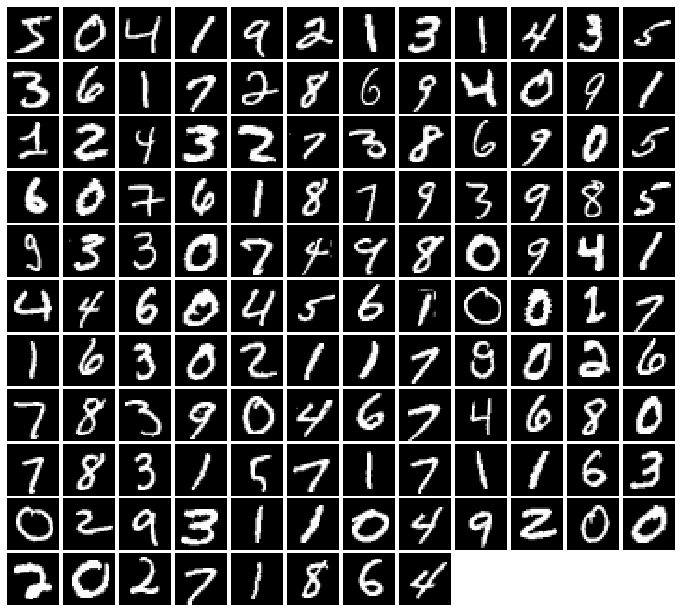

In [33]:
train_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

val_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

val_data = DataLoader(val_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze() # 可视化图片效果
show_images(imgs)


In [34]:
def discriminator():
    net = nn.Sequential(        
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    return net


In [35]:
def generator(noise_dim=NOISE_DIM):   
    net = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 784),
        nn.Tanh()
    )
    return net


In [36]:
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(logits_real, logits_fake): # 判别器的 loss
    size = logits_real.shape[0]
    if torch.cuda.is_available():
        true_labels = (torch.ones(size, 1)).float().cuda()
        false_labels = (torch.zeros(size, 1)).float().cuda()
    else:
        true_labels = torch.ones(size, 1).float()
        false_labels = torch.zeros(size, 1).float()

    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss


In [37]:
def generator_loss(logits_fake): # 生成器的 loss  
    size = logits_fake.shape[0]
    if torch.cuda.is_available():
        true_labels = torch.ones(size, 1).float().cuda()
    else:
        true_labels = torch.ones(size, 1).float()

    loss = bce_loss(logits_fake, true_labels)
    return loss


In [38]:
# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer


In [39]:
def train_a_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, 
                noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # 判别网络
            if torch.cuda.is_available():
                real_data = x.view(bs, -1).cuda() # 真实数据
            else:
                real_data = x.view(bs, -1)
                
            logits_real = D_net(real_data) # 判别网络得分
            
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
#             g_fake_seed = sample_noise.cuda()
            g_fake_seed = sample_noise

            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            if torch.cuda.is_available():
                g_fake_seed = sample_noise.cuda()
            else:
                g_fake_seed = sample_noise
                
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.item(), g_error.item()))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1


Iter: 0, D: 1.448, G:0.7226


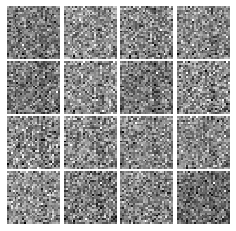

KeyboardInterrupt: 

In [40]:
if torch.cuda.is_available():
    D = discriminator().cuda()
    G = generator().cuda()
else:
    D = discriminator()
    G = generator()
    
D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train_a_gan(D, G, D_optim, G_optim, discriminator_loss, generator_loss)

In [21]:
def ls_discriminator_loss(scores_real, scores_fake):
    loss = 0.5 * ((scores_real - 1) ** 2).mean() + 0.5 * (scores_fake ** 2).mean()
    return loss

def ls_generator_loss(scores_fake):
    loss = 0.5 * ((scores_fake - 1) ** 2).mean()
    return loss


Iter: 0, D: 0.5524, G:0.4541


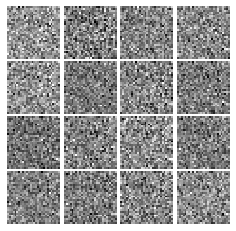


Iter: 250, D: 0.1375, G:0.3188


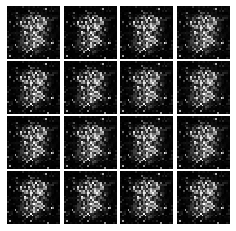


Iter: 500, D: 0.1062, G:0.6671


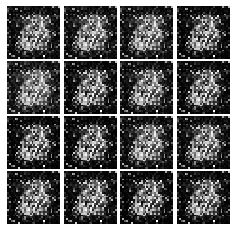


Iter: 750, D: 0.03145, G:0.696


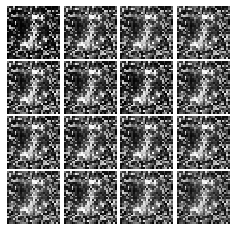


Iter: 1000, D: 0.2319, G:0.3949


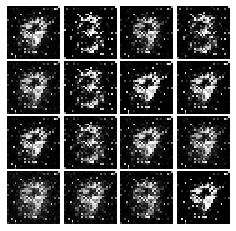


Iter: 1250, D: 0.07445, G:0.3497


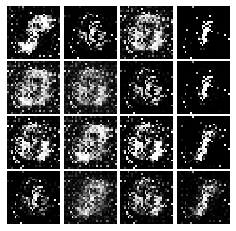


Iter: 1500, D: 0.09802, G:0.4375


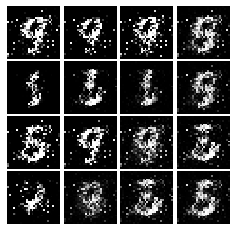


Iter: 1750, D: 0.07274, G:0.4313


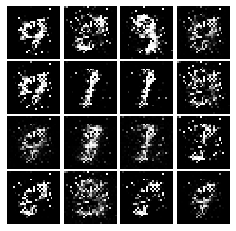


Iter: 2000, D: 0.06484, G:0.4234


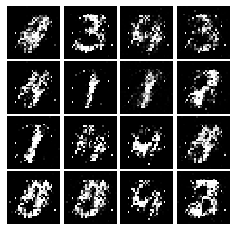


Iter: 2250, D: 0.1292, G:0.2251


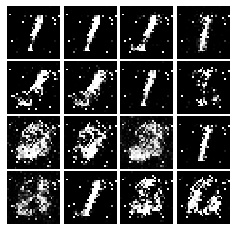


Iter: 2500, D: 0.06843, G:0.4039


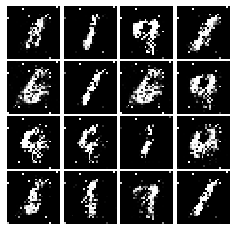


Iter: 2750, D: 0.09415, G:0.287


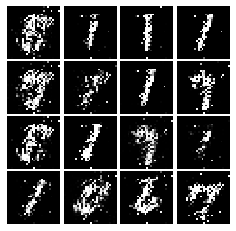


Iter: 3000, D: 0.1234, G:0.2687


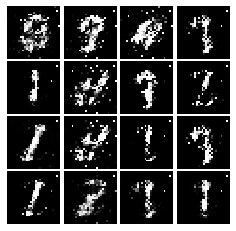


Iter: 3250, D: 0.1122, G:0.2785


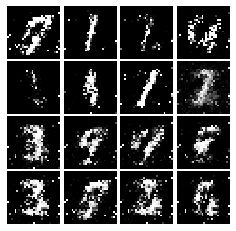


Iter: 3500, D: 0.1247, G:0.3149


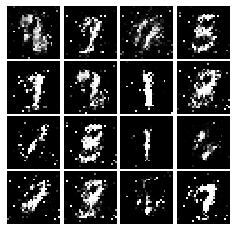


Iter: 3750, D: 0.1478, G:0.3002


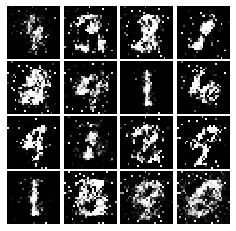

In [22]:
if torch.cuda.is_available():
    D = discriminator().cuda()
    G = generator().cuda()
else:
    D = discriminator()
    G = generator()

D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train_a_gan(D, G, D_optim, G_optim, ls_discriminator_loss, ls_generator_loss)

In [23]:
class build_dc_classifier(nn.Module):
    def __init__(self):
        super(build_dc_classifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


In [24]:
class build_dc_generator(nn.Module): 
    def __init__(self, noise_dim=NOISE_DIM):
        super(build_dc_generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128),
            nn.ReLU(True),
            nn.BatchNorm1d(7 * 7 * 128)
        )
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7) # reshape 通道是 128，大小是 7x7
        x = self.conv(x)
        return x


In [25]:
def train_dc_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, 
                noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # 判别网络

            if torch.cuda.is_available():
                real_data = x.cuda()
            else:
                real_data = x
                
            logits_real = D_net(real_data) # 判别网络得分
            
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布

            if torch.cuda.is_available():
                g_fake_seed = sample_noise.cuda()
            else:
                g_fake_seed = sample_noise

            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            
            if torch.cuda.is_available():
                g_fake_seed = sample_noise.cuda()
            else:
                g_fake_seed = sample_noise

            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.item(), g_error.item()))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1


Iter: 0, D: 1.379, G:0.8636


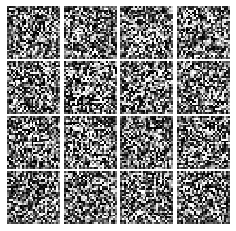

KeyboardInterrupt: 

In [27]:
if torch.cuda.is_available():
    D_DC = build_dc_classifier().cuda()
    G_DC = build_dc_generator().cuda()
else:
    D_DC = build_dc_classifier()
    G_DC = build_dc_generator()
    
D_DC_optim = get_optimizer(D_DC)
G_DC_optim = get_optimizer(G_DC)

train_dc_gan(D_DC, G_DC, D_DC_optim, G_DC_optim, discriminator_loss, generator_loss, num_epochs=5)


In [28]:
torch.cuda.is_available()

False